# Simple NN for Activity Classification
---
This notebook contains _incomplete_ code to train a neural net to predict an activity—running or walking—based on some provided user motion data. 

### The data

The data is a single csv file of accelerometer and gyroscope readings, collected from users' watches in 10 second intervals. Each data point is tagged as one of two activity types: running or walking. 

> Take a quick look at this data in Trove, where each column is described: [Run or walk data in Trove](https://trove.apple.com/dataset/run_walk_motion/1.0.0). 

### NN model creation

Andy has started the process of creating and training a neural net, but it will be up to you to fix his code, and improve upon it! 

The **goal** of this notebook is that you gain experience defining neural nets in PyTorch code in multiple ways, and gain some intuition for what choices you can make to get better performing models.

This notebook is broken up into the following NN model creation steps:
>1. Load the data
2. Create train/test dataloaders
3. Define a neural network
4. Train the model
5. Evaluate the performance of our trained model on a test dataset
6. Un-mount the Trove data
7. UX Considerations

Andy has gotten up to step 3, but his code to train a neural net is incomplete. Can you fix Andy's code, and create an NN model of your own that achieves better performance? 

As usual, your tasks will be marked as **TASKS** in markdown and as `## TODO's` in code. 

> **TASK**: Run the provided code to load the data and create train and test dataloaders. 

In [1]:
## run provided code

# import PyTorch libraries
import torch
from torch.utils.data import DataLoader
torch.manual_seed(0) # reproducibility

# import data libraries
import turitrove as trove
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/noahgallego/miniconda3/envs/deep-learning/lib/python3.8/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


---
# Load the Data


The following cells load run/walk activity data from Trove as a DataFrame.

In [2]:
# load data from Trove

TROVE_URI = 'dataset/run_walk_motion@1.0.0'
trove.umount(TROVE_URI)

# check for temp_data dir, if not found, make one and mount the dataset
if not os.path.isdir('temp_data'):
    os.makedirs('temp_data')

activity_dataset = trove.mount(TROVE_URI, 'temp_data')

dataset/run_walk_motion@1.0.0 is not mounted
Failed to connect to dataset run_walk_motion@1.0.0. Error:     <class 'turitrove._service.service_api.errors.TroveServiceNetworkError'>
    ClientRequestID: 5509adac-2aaa-4997-94ed-7be7a6412c0d, Function 'send_api_request' failed.: HTTPSConnectionPool(host='turitrove-api.apple.com', port=443): Max retries exceeded with url: /api/v2/terms/dataset/run_walk_motion/1.0.0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fc822a1dbb0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

    Status: None, System error. Most likely be an intermittent networking issue.
    Automatically retry for a limited time.
<class 'requests.exceptions.ConnectionError'>: HTTPSConnectionPool(host='turitrove-api.apple.com', port=443): Max retries exceeded with url: /api/v2/terms/dataset/run_walk_motion/1.0.0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fc82

100% (100 of 100) |######################################|Elapsed Time: 0:00:06


Mount succeeded
mount in progress: /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/data/raw
7.2MB disk space allocated for caching /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/data/raw


100% (100 of 100) |######################################|Elapsed Time: 0:00:00


Mount succeeded
dataset/run_walk_motion@1.0.0 is mounted at /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data


In [4]:
# make dataframe from csv path

data_path = activity_dataset.raw_file_path + '/'+ activity_dataset.primary_index['path'][0]
df = pd.read_csv(data_path)
df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


### Explore the data

Andy has done some data exploration to see the amount of data and number of users in the provided data.

> **TASK**: Write some code to answer the question: What percentage of this data is tagged as walking vs. running? 

The answer to this question should give you a good idea of whether you have _enough_ data for each class to make accurate predictions. 

In [5]:
# explore data a bit

# how much data?
print('# rows: ', len(df))
print()
# how many users?
print('Unique users: ', len(df['username'].unique()))
# descriptive stats
df.describe()

# rows:  88588

Unique users:  1


,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
count,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000,88588.000000
mean,0.522170,0.500801,-0.074811,-0.562585,-0.313956,0.004160,0.037203,0.022327
std,0.499511,0.500002,1.009299,0.658458,0.486815,1.253423,1.198725,1.914423
min,0.000000,0.000000,-5.350500,-3.299000,-3.753800,-4.430600,-7.464700,-9.480000
25%,0.000000,0.000000,-0.381800,-1.033500,-0.376000,-0.920700,-0.644825,-1.345125
50%,1.000000,1.000000,-0.059500,-0.759100,-0.221000,0.018700,0.039300,0.006900
75%,1.000000,1.000000,0.355500,-0.241775,-0.085900,0.888800,0.733700,1.398200
max,1.000000,1.000000,5.603300,2.668000,1.640300,4.874200,8.498000,11.266200


Text(0, 0.5, 'Count')

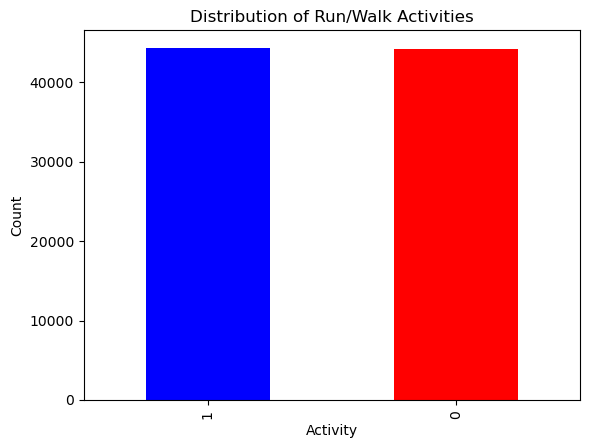

In [13]:
## TODO: Find the distribution of run/walk data
run_data = df[df['activity'] == 1]
walk_data = df[df['activity'] == 0]

activity_distribution = df['activity'].value_counts()
activity_distribution.plot(kind = 'bar', color = ['b', 'r'])

plt.title('Distribution of Run/Walk Activities')
plt.xlabel('Activity')
plt.ylabel('Count')

### Format and save for model training

This cell formats the DataFrame for model training; dropping non-featurized columns of data and moving the target to be the last column.

Finally, the formatted data is saved in a local `data/` directory as a binary file `run_walk_formatted.pkl`, which can be read in again, later in the notebook. 

In [14]:
# prep for model training, format data

# date, time, username columns dropped 
df_formatted = df.drop(['date', 'time', 'username'], axis=1)
# put target (activity) column last
column_order = ['wrist', 'acceleration_x', 'acceleration_y', 'acceleration_z', 
                'gyro_x', 'gyro_y', 'gyro_z','activity']
df_formatted = df_formatted.reindex(columns=column_order)
df_formatted.head()

,wrist,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,activity
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296,0
1,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269,0
2,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367,0
3,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336,0
4,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922,0


In [16]:
# save as pkl file 
if not os.path.isdir('data'):
    os.makedirs('data')
    
# save to local data/ dir
df_formatted.to_pickle('data/run_walk_formatted.pkl')

### Create a dataset

The following code creates one dataset that loads in the formatted csv as **tensors**; where each sample of data holds input features and one, corresponding target `activity` variable.

In [21]:
# create dataset

from helpers import RunWalkDataset
run_walk_dataset = RunWalkDataset('data/run_walk_formatted.pkl')

In [22]:
# print out a few (3) samples to see that it looks right
for i in range(3):
    sample = run_walk_dataset[i]
    print()
    print(sample)


(tensor([ 0.0000,  0.2650, -0.7814, -0.0076, -0.0590,  0.0325, -2.9296]), tensor([0.]))

(tensor([ 0.0000,  0.6722, -1.1233, -0.2344, -0.1757,  0.0208,  0.1269]), tensor([0.]))

(tensor([ 0.0000,  0.4399, -1.4817,  0.0722, -0.9105,  0.1063, -2.4367]), tensor([0.]))


### DataLoaders for Train/Test Datasets

DataLoaders allow you to do things like batch data, shuffle data, etc.—they are the standard way to iterate through data for training a PyTorch model.

The below code also _randomly_ splits the single, loaded RunWalkDataset into separate train and test datasets. 

> **TASK**: Critique Andy's method for splitting this data (you do not need to change the code).

> In a sentence or two, describe one thing about the below split is good practice and one thing that is not. 

**Answer:**
* **Good:** Andy correctly split the data into train/test sets at random which could help avoid bias.
* **Bad:** The data is organized by time originally, and splits at random aren't gnerally used for time-series data.

In [26]:
from torch.utils.data import random_split

# split data into train and test sets randomly ~ 80/20

# lengths or # samples in each dataset
split_80 = len(run_walk_dataset)*80//100
split_20 = len(run_walk_dataset) - split_80

# random split
train_dataset, test_dataset = random_split(run_walk_dataset, [split_80, split_20])

# how many samples per batch
batch_size = 64

# train and test loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

---
# Define the Neural Network Architecture

The architecture should be responsible for transforming input features into a single target class value between 0-1. 

> **TASK**: Something is missing from Andy's code, find out what it is and fix it so that you can train and calculate test metrics on this model.  


In [31]:
# importing NN modules
import torch.nn as nn
import torch.nn.functional as F

## TODO: Fix Andy's code

class AndyNet(nn.Module):
    
    ## Defines a single-layer NN
    def __init__(self, input_dim, output_dim):
        '''Defines layers of a neural network.
           :param input_dim: Number of input features
           :param output_dim: Number of outputs
         '''
        super(AndyNet, self).__init__()
                
        # define a linear layer, input > output
        self.fc1 = nn.Linear(input_dim, output_dim)
        
    
    ## Defines the feedforward behavior of the network
    def forward(self, x):
        '''Feedforward behavior of the net.
           :param x: A batch of input features
           :return: A batch of output values; predictions
         '''
        out = self.fc1(x)
        out = F.sigmoid(out) # <==== Re-Defined with F as sigmoid is not defined in Constructor
        return out 

In [32]:
# instantiating the simple NN with specified dimensions

input_dim = 7 # input feats
output_dim = 1 # one target value

model = AndyNet(input_dim, output_dim)

# print model layers (from init fn)
model

AndyNet(
  (fc1): Linear(in_features=7, out_features=1, bias=True)
)

### Define loss and optimization strategy

The loss function defines what a network tries to minimize in terms of comparing actual versus predicted values. 

In classification tasks, it is common to use a **cross entropy loss**; here since there is only one value output by the model—a value between 0-1—there is a special *binary* cross entropy loss, `BCELoss`. 

The optimizer defines how a neural network's weights update, as a result of trying to minimize the loss function. 

In [39]:
# loss function (categorical cross-entropy for classification)
criterion = nn.BCELoss()

# optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
# Train Loop

In the `helpers.py` file, there is code for a training loop that does the following:
* Iterate through the training data in batches provided by the `train_loader` 
* Calculate the loss (binary cross-entropy) and backpropagate to find the source of this error
* Update the weights of this NN to decrease the loss
* Return the trained model


In [40]:
from helpers import train

# number of epochs - times you iterate through the entire training dataset
n_epochs = 5

# call provided train function with all params
model = train(model, train_loader, n_epochs, optimizer, criterion)

Epoch: 1, Loss: 0.3624463125068143
Epoch: 2, Loss: 0.356206121104719
Epoch: 3, Loss: 0.3512215093854102
Epoch: 4, Loss: 0.3471379886761254
Epoch: 5, Loss: 0.3437262547979071


---
# Test the Trained Network

> **TASK**: Record the accuracy that Andy's network gets.

**Andy's test accuracy was**: 86%

In [43]:
from helpers import test_eval

# calculate test accuracy with helper function
num_correct = test_eval(model, test_loader, criterion)

print('Test accuracy: {:.6f}\n'.format(num_correct/len(test_dataset)))


Test accuracy: 0.860199



---
## An Improved NN

Now it's your turn to improve upon this code. 

> **TASK**: Using the *Sequential* module, create a new NN class that improves upon Andy's solution. For at least 2 experiments, record:
>* Hypothesis: What you think will improve a model's accuracy and why (e.g., changing the number of nodes in a hidden layer)
>* Experiment results: The resultant test accuracy

🏆 Your final experiment should aim for about **98% test accuracy**! 

In [70]:
## TODO: Define, train, and test your own NN, using the Sequential module
class NoahNet(nn.Sequential):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NoahNet, self).__init__(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
input_dim = 7
hidden_dim = 15
output_dim = 1

# loss function (categorical cross-entropy for classification)
criterion = nn.BCELoss()

# optimizer (stochastic gradient descent) and learning rate = 0.01
model = NoahNet(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

n_epochs = 20

# call provided train function with all params
model = train(model, train_loader, n_epochs, optimizer, criterion)

# calculate test accuracy with helper function
num_correct = test_eval(model, test_loader, criterion)

print('Test accuracy: {:.6f}\n'.format(num_correct/len(test_dataset)))

Epoch: 1, Loss: 0.34342935002183655
Epoch: 2, Loss: 0.1342862503912421
Epoch: 3, Loss: 0.09381943332730702
Epoch: 4, Loss: 0.07254005191992255
Epoch: 5, Loss: 0.05910675805852167
Epoch: 6, Loss: 0.05004892512922266
Epoch: 7, Loss: 0.04380108254612003
Epoch: 8, Loss: 0.040667596384496275
Epoch: 9, Loss: 0.03772268200037658
Epoch: 10, Loss: 0.035679425438613854
Epoch: 11, Loss: 0.03423999297835642
Epoch: 12, Loss: 0.0332272900634072
Epoch: 13, Loss: 0.032494533690939145
Epoch: 14, Loss: 0.03192227715559116
Epoch: 15, Loss: 0.03147461183887355
Epoch: 16, Loss: 0.03110874418452103
Epoch: 17, Loss: 0.03077869381873687
Epoch: 18, Loss: 0.03050665744163839
Epoch: 19, Loss: 0.030271978644441498
Epoch: 20, Loss: 0.030076481183378922
Test accuracy: 0.989502



## Un-mount your data

When you're totally done with the Trove dataset, un-mount it to clean uop this working directory.

> **TASK**: Un-mount the run/walk Trove data.

In [72]:
## TODO: Un-mount Trove data
trove.umount(TROVE_URI)

dataset/run_walk_motion@1.0.0 is umounted from /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/data/table
dataset/run_walk_motion@1.0.0 is umounted from /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/data/raw
folder /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/data is removed
terms.md is removed from /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/terms.md
readme.md is removed from /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/readme.md
info.json is removed from /Users/noahgallego/Desktop/Apple-OBC/Refactor_Activity_Classification/temp_data/run_walk_motion-1.0.0/info.json


---
# Further UX Considerations 📝 

At Apple, we are always thinking about the nuances of the user experience for different populations. This section represent answers to a set of questions that ask us to consider inclusive design practices, such as:

* **Failure cases**: What might go wrong with activity classification, and how does the likelihood of failures vary across users?
* **Delight**: What potential impact of a run/walk detection feature are you most excited about?

For any model you are thinking of putting into production or sharing with a larger team, you should critically consider the different tradeoffs and impacts such a trained model could have on different users. 

> **TASK**: In a sentence or a short bullet point, write down at least one potential failure case for run/walk detection and the user impact of that failure. 

> Additionally, share whether or not you would release your model more widely considering how _big_ this dataset, how many users it represents, and what data might be useful that is missing from this data.


**Your answer here**: 


### Potential Failure Case for Run/Walk Detection:
* Misclassifying a user’s running as walking (or vice versa) could lead to inaccurate calorie expenditure estimates, potentially affecting users who rely on precise activity tracking for health reasons, particularly athletes or individuals managing medical conditions.

### Would I Release the Model?
* I would release the model more widely only after addressing potential biases in the dataset, particularly ensuring representation across diverse body types, walking/running styles, and abilities. If the dataset is limited in these aspects, gathering more inclusive data would be necessary before scaling the model.